In [1]:
# When in collab, get PeopleArt from github

# !git clone https://github.com/BathVisArtData/PeopleArt.git
# !pip install lightning 
# !pip install xmltodict
# !pip install torchvision

## Задание: детекция людей на картинах (8 баллов + 3 дополнительных)

1. Скачайте датасет PeopleArt ([github](https://github.com/BathVisArtData/PeopleArt), [kaggle](https://www.kaggle.com/datasets/amanagr/people-art-dataset)), напишите `lightning.LightningDataModule` для работы с ним
2. Реализуйте `lightning.LightningModule` для обучения детектора.
3. Реализуйте расчёт и логирование метрик (mAP - обязательно, остальное - по желанию), можно использовать `torchmetrics` и любой понравившийся логгер (`tensorboard`, `aim`, `mlflow`, `wandb`, etc).
4. Реализуйте обучение модели с сохранением чекпоинта
5. Постарайтесь добиться mAP $\gt$ 0.3 Можно использовать предобученные модели из `torchvision`
6. В решении приложите к ноутбуку архив с логами и чекпоинтом модели

Критерии оценки:
1. (6 баллов) Реализованы модули для работы с данными и моделью и возможность запустить обучение и валидацию.
2. (2 балла) Удалось добиться $mAP > 0.3$

За что могут быть снижены баллы:
1. Ваш ноутбук падает с ошибкой - проверьте перед отправкой, что при перезагрузке кернела и последовательном исполнении ячеек всё запускается. 
2. Неаккуратное оформление - без фанатизма, просто постарайтесь, чтобы не было огромных функций в 30+ строк без комментариев, переменных с именами в один символ, слишком много ячеек, где вы просто что-то отлаживаете без пояснений
3. Не приложены логи и чекпоинты - без них будет сложно понять, что у вас получилось

Советы:
- если вы сможете большую часть своего кода вынести в `.py` файлы, а в ноутбуке будете их импортировать - будет совсем хорошо, тогда ноутбук получится лаконичным и чистым. 
- для автоматического форматирования ноутбуков есть полезный пакет `nbqa`, можно обработать финальную версию хотя бы так:
  ```bash
  nbqa isort peopleart_detection.ipynb
  nbqa black peopleart_detection.ipynb
  ```

In [2]:
import torchvision
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt

import requests
import matplotlib.pyplot as plt
from PIL import Image, ImageFont
import torch
from torchvision import transforms

### 1. Подготовка данных

Для того, чтобы можно было использовать модели из `torchvision.models.detection`, нужно обеспечить правильный формат данных.

`Dataloader` должен возвращать батчи вида `tuple[list[Tensor], list[dict[str, Tensor]]]`, то есть пару списков:
- с изображениями (в виде тензоров, могут быть любого размера)
- и соответствующей аннотацией (словари, где обязательно есть поля `boxes` и `labels`)

Пример батча - ниже в переменной `batch`

Для реализации модуля данных:
1. Реализуйте подкласс `torch.utils.data.Dataset`, где будет реализован парсинг аннотаций (они в XML, вам пригодится пакет `xmltodict`) и сбор данных в пары изображение-аннотация, причём аннотации уже должны быть приведены в нужный формат, как в примере ниже, а метод `__getitem__` должен возвращать `tuple[Tensor, dict[str, Tensor]]`
2. Реализуйте подкласс `lightning.LightningDataModule`, который будет создавать датасеты для подвыборок (train/val/test) и загрузчики данных для них. Для упаковки данных в батчи вам нужно будет определить аргумент `collate_fn` для `torch.utils.data.DataLoader`, иначе код будет падать при попытке сложить изображения разного размера.
3. Примечание: если вы захотите описать свою модель без использования архитектур из `torchvision`, то на этапе упаковки в батчи было бы логично привести изображения к единому размеру, например сделать размер большей стороны равным $416$, а затем добавить zero padding для того, чтобы итоговый размер изображения был равен $416 \times 416$. Это позволит обрабатывать батч параллельно на GPU. При этом аннотацию нужно изменить согласованным образом! В `albumentations` есть нужные трансформации, которые работают одновременно с изображением и разметкой, поищите их. При работе с детекторами из `torchvision` эти операции обычно делаются где-то внутри класса модели. Сможете найти их, например, для `SSD`?

Пример данных: что-то такое может храниться внутри вашего класса для датасета, но сами изображения лучше читать с диска внутри метода `__getitem__`

In [3]:
from Dataset import PeopleArtDataset
dataset = PeopleArtDataset("PeopleArt")
data_sample_batch = [dataset[0], dataset[10], dataset[2]]

Можно посмотреть на пример изображений с аннотациями:

Font=ROCK


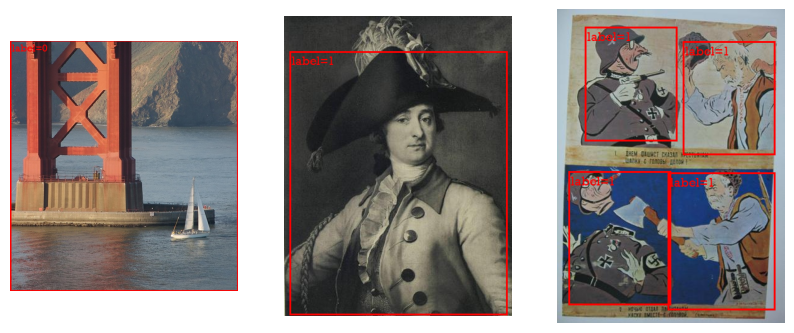

In [4]:
fig, axes = plt.subplots(ncols=len(data_sample_batch), figsize=(10, 7))
font = "ROCK" # '-'.join(ImageFont.load_default(20).getname())
print(f"Font={font}")
for sample, ax in zip(data_sample_batch, axes):
    # нарисуем рамки
    detection = draw_bounding_boxes(
        transforms.Compose([transforms.ConvertImageDtype(torch.uint8)])(sample[0]),
        boxes=sample[1]["boxes"],
        labels=[f"label={label}" for label in sample[1]["labels"]],
        width=3,
        font=font, # Arial, LiberationSans-Bold,  LatinModernSans
        font_size=20,
        colors="red",
    )
    detection: Image.Image = torchvision.transforms.ToPILImage()(detection)
    ax.imshow(detection)
    ax.set_axis_off()

Вот как должен выглядеть батч:

### Модели из `torchvision`

Разберём для примера `SSD`, вы можете взять любую другую модель, в том числе написать всё самостоятельно

In [5]:
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights

# создадим модель с весами COCO
weights = SSDLite320_MobileNet_V3_Large_Weights.COCO_V1
ssd = ssdlite320_mobilenet_v3_large(weights=weights)

# получим батч
image_transform = weights.transforms()
image_tensors = [image_transform(x) for x, _ in data_sample_batch]
labels = [y for _, y in data_sample_batch]
batch = (image_tensors, labels)

#### Вывод модели в режиме инференса

In [6]:
ssd.eval()
preds = ssd.forward(image_tensors)
print(preds[0].keys())

dict_keys(['boxes', 'scores', 'labels'])


Отрисуем предсказания:

D:\Users\DEVELOPER\My files\Study\SPbU\4\DeepLearning\people-art-detection\DeepLearningEnv\Lib\site-packages\torchvision\utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


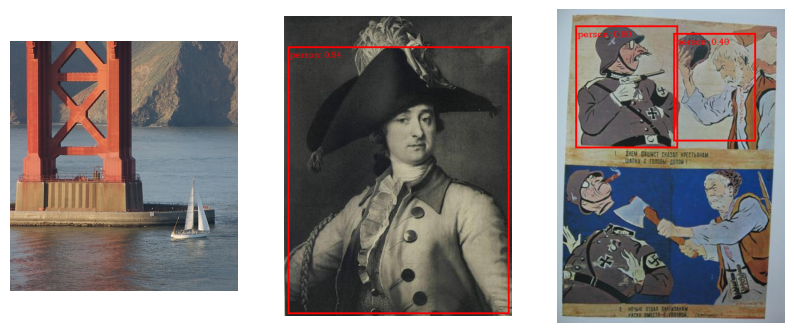

In [7]:
classes = weights.meta["categories"]

fig, axes = plt.subplots(ncols=len(data_sample_batch), figsize=(10, 7))
for sample, prediction, ax in zip(data_sample_batch, preds, axes):
    # выберем только объекты с оценкой уверенности >= 0.2 и соответствующие классу person
    mask = (prediction["scores"] >= 0.2) * (prediction["labels"] == 1)
    boxes = prediction["boxes"][mask]
    pred_labels = prediction["labels"][mask]
    scores = prediction["scores"][mask]
    # нарисуем рамки
    detection = draw_bounding_boxes(
        transforms.Compose([transforms.ConvertImageDtype(torch.uint8)])(sample[0]),
        boxes=boxes,
        labels=[f"{classes[int(label)]}: {float(score):.2f}" for label, score in zip(pred_labels, scores)],
        width=3,
        font=font, # Arial, LiberationSans-Bold
        font_size=15,
        colors="red",
    )
    detection: Image.Image = torchvision.transforms.ToPILImage()(detection)
    ax.imshow(detection)
    ax.set_axis_off()

#### Вывод модели в режиме обучения

In [8]:
ssd.train()
preds = ssd.forward(image_tensors, labels)
print(preds)

{'bbox_regression': tensor(1.7530, grad_fn=<DivBackward0>), 'classification': tensor(2.3417, grad_fn=<DivBackward0>)}


Модель возвращает уже рассчитанные значения ошибок, то есть для обучения почти всё готово.

Вам останется только обернуть такую модель в `LightningModule`, добавив расчёт метрик и логирование.

Будьте внимательны: некоторые модели из `torchvision` (`SSD` в частности) в качестве нулевого класса заводят специальный класс `__background__`, поэтому перед запуском обучения убедитесь, что ваша разметка из датамодуля приведена в соответствие с разметкой, которую будет возвращать модель.

Полезная штука для дебага: аргумент `overfit_batches` в `lightning.Trainer`, попробуйте переобучить модель на одном батче и отследите, что ваши метрики растут, приближаясь к 100% точности.

In [19]:
from Module import PeopleArtModule
from DataModule import PeopleArtDataModule
import lightning

dataloader = PeopleArtDataModule("PeopleArt")
model = PeopleArtModule()

# trainer = lightning.Trainer(fast_dev_run=10)
# trainer = lightning.Trainer(max_epochs=5, log_every_n_steps=1) # overfit_batches=1
trainer = lightning.Trainer(max_epochs=100, log_every_n_steps=5) # overfit_batches=1
trainer.fit(model=model, train_dataloaders=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name    | Type                 | Params
-------------------------------------------------
0 | ssd     | SSD                  | 3.4 M 
1 | model   | ObjectDetection      | 0     
2 | metrics | MeanAveragePrecision | 0     
-------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.760    Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.


In [21]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/  --host localhost --port 6006

### Бонус (3 балла): YoloV8 